# Robustness Noise 
In order to understand the results better from the testing so far, in particular the plots, we want to analyse how noise influences our computations.
This serves the overall goal of improving our method with noisy data.
Following questions arise:

How can we bound the finite difference method?

How stable is the SVD to noise?

We only consider noise which is normally distributed? Does this influence our result?

What is the relation between the highest and the lowest singular value? Do they grow/shrink in a similar way when confronted with noise?

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt

## SVD Robustness Noise
There is a theorem and a corollary:

Theorem 2.18 (Mirsky). If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\sqrt{\sum_{k=1}^{r}|\sigma_k(A+E) - \sigma_k(A)|} \leq \lVert E \rVert_F$

Corollary:
If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\forall k \ |\sigma_k(A+E) - \sigma_k(A)| \leq \lVert E \rVert$

#### 1. What is the spectral and Frobenius norm of random noise matrices?

In [2]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -10,10
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
matrix[:, 1] = alpha*matrix[:,2]
print(matrix)

[[ 1.78705507  2.97583222  7.65909467]
 [-5.00402045  0.5142115   1.3234599 ]
 [-3.9012779  -2.31531475 -5.95907752]
 [-7.47422942 -0.18401787 -0.47361886]
 [-4.4152157   1.07749753  2.77322611]
 [ 9.70728291  0.11534726  0.29687682]
 [ 9.48496239  3.53716141  9.10382446]
 [ 1.94501151  3.61746257  9.31050081]
 [-0.95822106  2.99293842  7.70312204]
 [-3.00246931  2.48283057  6.39022397]]


In [3]:
print(matrix_rank(matrix),svd(matrix, compute_uv=False))
print(np.linalg.norm(matrix))
print(np.linalg.norm(matrix,ord=2))

2 [2.22934014e+01 1.58051228e+01 1.21425117e-15]
27.327598722788625
22.293401397906102


Add noise

In [4]:
#np.random.seed(12)
target_noise=1e-3
var = target_noise * np.sqrt(np.mean(np.square(matrix)))
noise = np.random.normal(0, var, size=matrix.shape)
matrix_noise = matrix + noise
print(f"Added Gaussian noise with variance {var}")

Added Gaussian noise with variance 0.004989314087640232


In [5]:
print("Noise Matrix")
#print(noise)
print(f"Matrix rank: {matrix_rank(noise)}, SVD: {svd(noise, compute_uv=False)}")
print(f"Frobenius norm:\t {np.linalg.norm(noise)}")
print(f"Spectral norm:\t {np.linalg.norm(noise,ord=2)}")

Noise Matrix
Matrix rank: 3, SVD: [0.02093881 0.01419844 0.00700195]
Frobenius norm:	 0.026249893102237597
Spectral norm:	 0.02093881331996342


Print SVD and matrix rank with additional noise

In [6]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t \t matrix rank \t svd \t \t \t \t \t \t \t Frobenius \t \t \t Spectral")
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix + noise
    print(f" {target_noise}      \t \t {matrix_rank(matrix_noise)} \t \t {svd(matrix_noise, compute_uv=False)}     \t {np.linalg.norm(noise)}      \t {np.linalg.norm(noise,ord=2)}")

Noise level 	 	 matrix rank 	 svd 	 	 	 	 	 	 	 Frobenius 	 	 	 Spectral
 0      	 	 2 	 	 [2.22934014e+01 1.58051228e+01 1.21425117e-15]     	 0.0      	 0.0
 1e-10      	 	 3 	 	 [2.22934014e+01 1.58051228e+01 1.38114735e-09]     	 2.155651642993718e-09      	 1.7143550324233435e-09
 1e-09      	 	 3 	 	 [2.22934014e+01 1.58051228e+01 1.98275730e-08]     	 3.0509845986114215e-08      	 2.3777688110447977e-08
 1e-08      	 	 3 	 	 [2.22934014e+01 1.58051229e+01 1.17945925e-07]     	 2.899345845609937e-07      	 2.562499370942348e-07
 1e-07      	 	 3 	 	 [2.22934018e+01 1.58051235e+01 1.85548249e-06]     	 2.654850745556788e-06      	 2.0706500227609775e-06
 1e-06      	 	 3 	 	 [2.22934009e+01 1.58051280e+01 1.73940128e-05]     	 3.046722856985354e-05      	 2.1891752649495223e-05
 1e-05      	 	 3 	 	 [2.22933319e+01 1.58050349e+01 1.96320744e-04]     	 0.0003486585473514126      	 0.00026132542808256145
 0.0001      	 	 3 	 	 [2.22931945e+01 1.58046103e+01 8.70992224e-04]     	 0.0

Although the Frobenius Norm might not be that high in relation to the highest singular value. In relation to the smallest singular value it can be quite significant. Thus, the changes in the smallest singular value can be more disturbing for our purpose.

#### 2. What is the ratio between the smallest and biggest singular value?

The idea is if $A \in \mathbb{R}^{nxm}$ for $m<n$ has full rank $\frac{\sigma_1}{\sigma_m} < \infty$, but if it does not have full rank $\frac{\sigma_1}{\sigma_m} = \infty$

The bound that we use in the following is for $ \|B\|=max(\frac{1}{\sigma_n},\frac{\sigma_1}{\sigma_n^2}), \ \|B\|_F^2=\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2$
\begin{equation}
    | \frac{\sigma_1(A+E)}{\sigma_n(A+E)} - \frac{\sigma_1(A)}{\sigma_n(A)} | < \|B\|\|E\|
\end{equation}

In [7]:
# This calculates the above given bound
def calc_bound_ratio(sv_max,sv_min,noisematrix):
    #E=np.linalg.norm(noisematrix) #Spectral: order=2, Frobenius: default
    B=np.sqrt(1/sv_min+(sv_max/sv_min**2)**2)
    E=np.linalg.norm(noisematrix,ord=2) #Spectral: order=2, Frobenius: default
    #B=max(1/sv_min,sv_max/sv_min**2)
    return E*B

In [8]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
#matrix = np.random.random(size=(rows,cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
#matrix[:, 1] = matrix[:,2]
#matrix[:,0] = np.random.rand()*matrix[:,2]
#matrix[:, 2] *=1e6
#matrix[:, 0] *=1e6
print(matrix)

0.5094831958915537
[[-2.58772637 -3.47779203  0.47250107]
 [-4.44784092 -2.41410307 -2.20553215]
 [-2.39833543 -4.49584342 -1.85091764]
 [-4.69000193 -3.12843552 -1.0100523 ]
 [-4.60749243  0.07651174 -4.22191349]
 [-0.34315672  0.24689365 -4.17840192]
 [-3.93082026 -3.35470125 -3.45416258]
 [ 0.57403746 -0.06647339  0.18113305]
 [-4.27164844 -3.74317515 -4.05144109]
 [-1.49174603 -4.02393946 -3.67021374]]


In [9]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio big/smalles singular value: {sv[0]/sv[-1]}")
print(f"Bound: {calc_bound_ratio(sv_max,sv_min,np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 3
Singular values : [15.43989829  5.73222045  4.08609833]
Ratio big/smalles singular value: 3.778640901495907
Bound: 0.0


In [10]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t \t \t  ratio \t bound")
ratios =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    bound=calc_bound_ratio(sv_max,sv_min,noise)
    ratios.append(np.abs(ratio-sv_max/sv_min))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t \t\t{ratio:3.3e}  \t {bound:3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	 	 	  ratio 	 bound
 0	 	 3 	 	 [15.43989829  5.73222045  4.08609833] 	 		3.779e+00  	 0.000e+00
 1e-10	 	 3 	 	 [15.43989829  5.73222045  4.08609833] 	 		3.779e+00  	 1.264e-09
 1e-09	 	 3 	 	 [15.43989828  5.73222045  4.08609833] 	 		3.779e+00  	 1.680e-08
 1e-08	 	 3 	 	 [15.43989826  5.73222046  4.08609838] 	 		3.779e+00  	 1.651e-07
 1e-07	 	 3 	 	 [15.4398985   5.73222082  4.08609773] 	 		3.779e+00  	 1.396e-06
 1e-06	 	 3 	 	 [15.43989638  5.73221258  4.08610182] 	 		3.779e+00  	 1.372e-05
 1e-05	 	 3 	 	 [15.43989887  5.73215265  4.08605745] 	 		3.779e+00  	 1.486e-04
 0.0001	 	 3 	 	 [15.44013915  5.73225778  4.08619959] 	 		3.779e+00  	 9.878e-04
 0.001	 	 3 	 	 [15.43405709  5.73338696  4.08440446] 	 		3.779e+00  	 1.321e-02
 0.01	 	 3 	 	 [15.51622551  5.72221893  4.09638391] 	 		3.788e+00  	 1.560e-01
 0.1	 	 3 	 	 [15.55174346  6.00878031  4.35498249] 	 		3.571e+00  	 9.975e-01


Since for matrix with not full rank the bound is very high, I want to test the deviation for the same noise level

In [11]:
trials=10
noise_level=1e-10
differences=[]
bounds=[]
print(f"Noise level:  {noise_level}, Number trials: {trials}, True ratio: {sv_max/sv_min}")
print("Trial \t matrix rank \t sv \t \t \t \t \t \t \t  ratio \t \t bound \t \t \t difference")
for trial in range(trials):
    var = noise_level * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = calc_bound_ratio(sv_max,sv_min,noise)
    bounds.append(bound)
    differences.append(np.abs(ratio-sv_max/sv_min))
    print(f" {trial}\t \t {matrix_rank(matrix_noise)} \t {sv}   \t  {ratio:3.3e}   \t \t {bound:3.3e} \t \t {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level:  1e-10, Number trials: 10, True ratio: 3.778640901495907
Trial 	 matrix rank 	 sv 	 	 	 	 	 	 	  ratio 	 	 bound 	 	 	 difference
 0	 	 3 	 [15.43989829  5.73222045  4.08609833]   	  3.779e+00   	 	 1.446e-09 	 	 2.045e-10
 1	 	 3 	 [15.43989829  5.73222045  4.08609833]   	  3.779e+00   	 	 1.391e-09 	 	 2.873e-10
 2	 	 3 	 [15.43989829  5.73222045  4.08609833]   	  3.779e+00   	 	 1.730e-09 	 	 1.218e-10
 3	 	 3 	 [15.43989829  5.73222045  4.08609833]   	  3.779e+00   	 	 1.503e-09 	 	 1.502e-10
 4	 	 3 	 [15.43989829  5.73222045  4.08609833]   	  3.779e+00   	 	 1.014e-09 	 	 3.972e-10
 5	 	 3 	 [15.43989829  5.73222045  4.08609833]   	  3.779e+00   	 	 1.256e-09 	 	 4.073e-11
 6	 	 3 	 [15.43989829  5.73222045  4.08609833]   	  3.779e+00   	 	 9.943e-10 	 	 7.217e-12
 7	 	 3 	 [15.43989829  5.73222045  4.08609833]   	  3.779e+00   	 	 1.124e-09 	 	 2.008e-11
 8	 	 3 	 [15.43989829  5.73222045  4.08609833]   	  3.779e+00   	 	 1.363e-09 	 	 5.017e-10
 9	 	 3 	 [15.439898

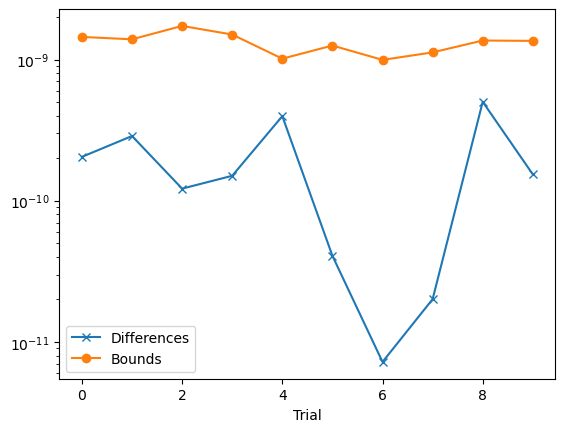

In [12]:
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.yscale('log')
plt.xlabel('Trial')
plt.legend()

Plot range of sv_max/sv_min: $$\max(0,\frac{\sigma_1(A)}{\sigma_n(A)}  - \|B\|\|E\|) <\frac{\sigma_1(A+E)}{\sigma_n(A+E)} < \frac{\sigma_1(A)}{\sigma_n(A)} | + \|B\|\|E\|$$

In [13]:
#This returns two values
#lower_bound: omax/omin -BE
#upper_bound: BE + omax/min
def calc_range_ratio(sv_max,sv_min,noisematrix):
    #E=np.linalg.norm(noisematrix) #Spectral: order=2, Frobenius: default
    B=np.sqrt(1/sv_min+(sv_max/sv_min**2)**2)
    E=np.linalg.norm(noisematrix,ord=2) #Spectral: order=2, Frobenius: default
    lower_bound=max(0,sv_max/sv_min - B*E)
    upper_bound=B*E + sv_max/sv_min
    return lower_bound, upper_bound

In [14]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:, 1] *=1e-6
#matrix[:, 1] = matrix[:,2]
print(matrix)

0.1937764301621494
[[ 1.03642913e-01  3.67478613e-07 -4.05796834e+00]
 [-1.17395882e+00 -3.84435018e-06 -8.08774386e-01]
 [-3.26888165e+00 -4.09826060e-06 -3.98876275e+00]
 [-8.18899409e-01 -4.54849128e-06 -9.32744144e-01]
 [ 6.58994223e-01 -2.81589187e-07 -4.86889721e+00]
 [-2.74824814e+00 -2.31218354e-06 -7.35894446e-01]
 [-2.20282007e+00 -4.78268921e-06 -3.05606376e+00]
 [-1.59649112e+00 -1.91654907e-06 -2.30845530e+00]
 [-3.72536029e+00 -2.84861400e-06 -4.03534882e+00]
 [-2.01115902e+00  8.76870851e-07 -3.17384940e+00]]


In [15]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio big/smalles singular value: {sv[0]/sv[-1]}")
print(f"Bound: {calc_bound_ratio(sv_max,sv_min,np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 3
Singular values : [1.11736671e+01 4.51449839e+00 6.17039546e-06]
Ratio big/smalles singular value: 1810851.0436050196
Bound: 0.0


In [16]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t \t \t \t ratio \t \t bound")
ratios =[]
ups,lows =[],[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    bound = calc_bound_ratio(sv_max,sv_min,noise)
    bounds.append(bound)
    low,up=calc_range_ratio(sv_max,sv_min,noise)
    ratios.append(ratio)
    lows.append(low)
    ups.append(up)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv}   \t  \t{ratio:3.3e}  \t {bound:3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	 	 	 	 ratio 	 	 bound
 0	 	 3 	 	 [1.11736671e+01 4.51449839e+00 6.17039546e-06]   	  	1.811e+06  	 0.000e+00
 1e-10	 	 3 	 	 [1.11736671e+01 4.51449839e+00 6.17049871e-06]   	  	1.811e+06  	 3.227e+02
 1e-09	 	 3 	 	 [1.11736671e+01 4.51449839e+00 6.17282253e-06]   	  	1.810e+06  	 2.896e+03
 1e-08	 	 3 	 	 [1.11736671e+01 4.51449838e+00 6.17433932e-06]   	  	1.810e+06  	 2.891e+04
 1e-07	 	 3 	 	 [1.11736668e+01 4.51449809e+00 6.20927628e-06]   	  	1.800e+06  	 2.962e+05
 1e-06	 	 3 	 	 [1.11736671e+01 4.51449902e+00 1.61691907e-05]   	  	6.910e+05  	 3.363e+06
 1e-05	 	 3 	 	 [1.11736757e+01 4.51452384e+00 5.83581316e-05]   	  	1.915e+05  	 2.781e+07
 0.0001	 	 3 	 	 [1.11738858e+01 4.51462214e+00 5.47248962e-04]   	  	2.042e+04  	 2.522e+08
 0.001	 	 3 	 	 [1.11747065e+01 4.51155768e+00 5.90555424e-03]   	  	1.892e+03  	 2.317e+09
 0.01	 	 3 	 	 [11.20419427  4.50091811  0.07694751]   	  	1.456e+02  	 2.638e+10
 0.1	 	 3 	 	 [11.25484495  4.

In [17]:
print(lows)
print(ups)

[1810851.0436050196, 1810528.3886062412, 1807955.4735083221, 1781941.4934878482, 1514663.8909505436, 0, 0, 0, 0, 0, 0]
[1810851.0436050196, 1811173.698603798, 1813746.613701717, 1839760.593722191, 2107038.196259496, 5174041.678526676, 29617218.00777684, 254020282.2383605, 2318959587.0865936, 26377430890.837543, 263365626556.57104]


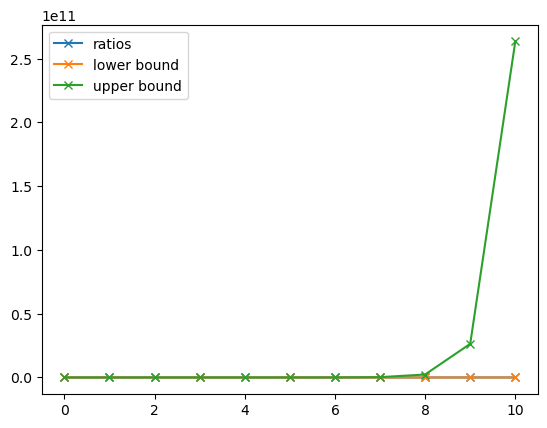

In [18]:
plt.plot(ratios,marker='x',label="ratios")
plt.plot(lows,marker='x',label="lower bound")
plt.plot(ups,marker='x',label="upper bound")
plt.legend()
#plt.yscale('log')

## Finite Difference Noise

We can find the coefficients use to calculate the finite differences for different orders in https://en.wikipedia.org/wiki/Finite_difference_coefficient. Calculator https://web.media.mit.edu/~crtaylor/calculator.html<br>
Assuming we have equispaced data for x,and we can bound the measurement error by $\epsilon > 0$ i.e. $||u-\tilde{u}||_{\infty}< \epsilon$ and the third derivative of u
is bounded by $M(t, x) > 0$ on each interval $[x − h, x + h]$. Then, we get tha
$$|u_x(t, x) − \tilde{u}_x(t, x)| ≤ \frac{\epsilon}{h} + \frac{h^2}{6}M(t,x)$$
is the 2nd order centered finite differences approximation of the derivative of $\tilde{u}$.

TODO: error bound for different orders, centered and left-off-centered/backward differences (even/odd order)?<br>
Question: do the same error bounds count at the boundary values of u?? For centered Differences no-> can lead to wron errorbound especially since exp has high values at boundary point

For even order: centered differenced, for uneven order backward differences:<br>
order = 1: <br>
Approximation: $\frac{u(x)-u(x-h)}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h}{2}||u'||_{\infty}+\frac{2\epsilon}{h}$ 
<br>
order = 2: <br>
Approximation: $\frac{u(x+\frac{h}{2})-u(x-\frac{h}{2})}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^2}{3}||u^3||_{\infty}+\frac{2\epsilon}{h}$ <br>
(Here we use h/2 since for h the calculation did not work out -> makes more sense???)
order = 4: <br>
Approximation: see book or wiki,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^4}{30}||u^5||_{\infty}+\frac{9 \epsilon}{6h}$ <br>

In [117]:
from test_data import create_data_2d

n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)


a=np.random.randn()
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
"""
dx=x[1]-x[0]

In [100]:
ux_fd = ps.FiniteDifference(order=3,d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux_fd.flatten()
g= np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print(g.shape)
print(f"Matrix rank = {matrix_rank(g)}, svd = {svd(g, compute_uv=False)}")

(40000, 2)
Matrix rank = 2, svd = [4.23652096e+02 7.63591380e-07]


### Check difference between noisy derivative and correct derivative

To approximate $\|u'-\tilde{u}'\|$

General formula for central differences: $$ \text{sum over ceofficients} \frac{\epsilon}{h} + h^{order} \|u^{order+1}\|_{\infty}\frac{(order/2)!^2}{(order+1)!}$$

For backward differences: $$ \text{sum over ceofficients}\frac{\epsilon}{h} + h^{order}\|u^{order+1}\|_{\infty} \frac{1}{order+1}$$

Here compute functions for computing lagrange coefficients and sum(for calculating measurment error) 
$$L_{n,k}(x) =\prod_{i=0,i\neq k}^n \frac{x-x_i}{x_k-x_i}$$
$$  L'_{n,k}(x) = [\prod_{i=0,i\neq k}^n \frac{1}{x_k-x_i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (x-x_i)
$$
$$  L'_{n,k}(x_l)= h^{-1}[\prod_{i=0,i\neq k}^n \frac{1}{k-i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (l-i) = h^{-1} \sum_{j=0,j\neq k}^n \frac{1}{k-j} \prod_{i=0,i\neq k,j}^n \frac{l-i}{k-i}$$
Note here n stands for the order as well. (wiki link to polynomial and derivatives: https://en.wikipedia.org/wiki/Lagrange_polynomial)

#### Functions

In [101]:
"""
n: number of data points used for approximation/ order
k: number of lagrange coefficient
l: input to lagrange coefficient: x = x_l = x+ hl
"""
#Computes the coefficients of the derivitve of the kth Lagrangian Coefficients
#These are also the coefficients used for finite differences
def lagrange_coefficient_derivative(n,k,l):
    erg=0.0        
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                  if i!=k and i!=j:
                    tmp *=(l-i)/(k-i)
                    #print(f"l-k = {l}-{i}")
            tmp*=1.0/(k-j)
            erg+=tmp
    return erg
    
#Sums up the above coefficients
#needed for measurment error
def sum_lagrange_coefficient_derivative(n,l):
    erg=0.0
    for k in range(n+1):
        #print(f"L({n},{k},{l}) = {lagrange_coefficient_derivative(n,k,l)}")
        erg+= np.abs(lagrange_coefficient_derivative(n,k,l))
    return erg

In [102]:
# Approximation error central differences: reduces with higher order n
def appr_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    bound = (np.math.factorial(int(n/2))**2)/np.math.factorial(n+1)
    return bound
    
# Approximation error backward differences: reduces with higher order n
def appr_error_backward_diff(n):
    return 1/(n+1)

# Measurement error central differences
def meas_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    erg=sum_lagrange_coefficient_derivative(n,n/2)
    return erg
    
# Measurement error backward differences
def meas_error_backward_diff(n):
    erg=sum_lagrange_coefficient_derivative(n,0)
    return erg

In [104]:
"""
eps: measurement error+round of error (Does it make sense to add machine precision?)
h: dx for equispaced data
M: bound on (order+1)th derivative
"""
def error_bound(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_app=appr_error_backward_diff(order)
        C_meas=meas_error_backward_diff(order)
    #print(f" C_meas*eps/h + (h**order)*M*C_app = {C_meas:2.3e}*{eps:2.3e}/{h:2.3e} + {h**order:2.3e}*{M:2.3e}*{C_app:2.3e}")    
    return C_meas*eps/h + (h**order)*M*C_app
            
def infinity_norm(x):
    return np.max(np.abs(x))

#### Plots for analysining the "knick" in finite differences error

The Measurment error increases while the approximation error decreases. If in the beginning the measurment error is strictly smaller than the approximation error this can lead to the knick". If not than no "knick" should be visible.

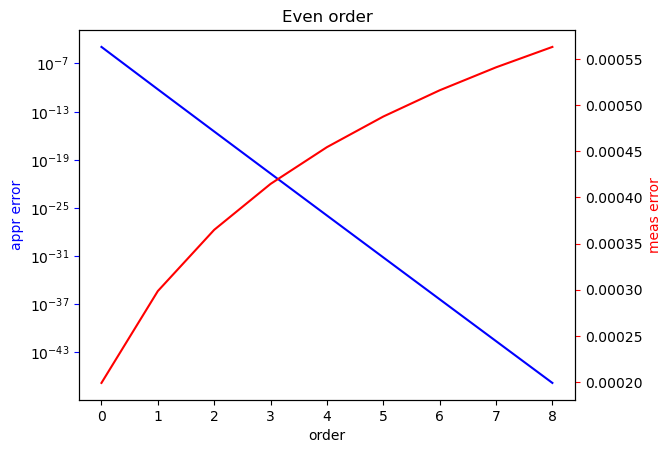

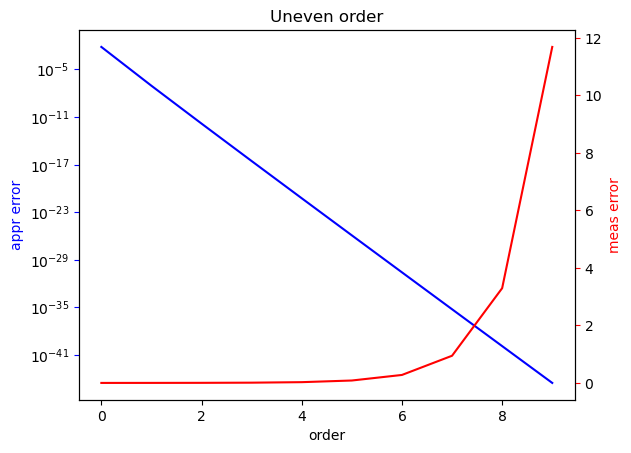

In [105]:
meas_error_list_even=[]
app_error_list_even=[]
meas_error_list_uneven=[]
app_error_list_uneven=[]
h=dx
eps=1e-6#np.finfo(float).eps # if this is big enough no knick will be visible, note it mus be very small for the knick to be visple
M=2.78
for order in range(1,20,1):
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)*h**order*M
        C_meas=meas_error_central_diff(order)*eps/h
        app_error_list_even.append(C_app)
        meas_error_list_even.append(C_meas)
    else: # odd order
        C_app=appr_error_backward_diff(order)*h**order*M
        C_meas=meas_error_backward_diff(order)*eps/h
        app_error_list_uneven.append(C_app)
        meas_error_list_uneven.append(C_meas)

fig, ax1 = plt.subplots()
plt.title("Even order")
ax1.set_xlabel('order')
color = 'blue'
ax1.set_ylabel('appr error', color=color)
ax1.plot(app_error_list_even,color=color)
ax1.tick_params(axis='y', color=color)
plt.yscale('log')

ax2 = ax1.twinx()  
color='red'
ax2.set_ylabel('meas error', color=color)  
ax2.plot(meas_error_list_even, color=color)
ax2.tick_params(axis='y', color=color)

fig, ax1 = plt.subplots()
plt.title("Uneven order")
ax1.set_xlabel('order')
color = 'blue'
ax1.set_ylabel('appr error', color=color)
ax1.plot(app_error_list_uneven,color=color)
ax1.tick_params(axis='y', color=color)
plt.yscale('log')

ax2 = ax1.twinx()  
color='red'
ax2.set_ylabel('meas error', color=color)  
ax2.plot(meas_error_list_uneven, color=color)
ax2.tick_params(axis='y', color=color)

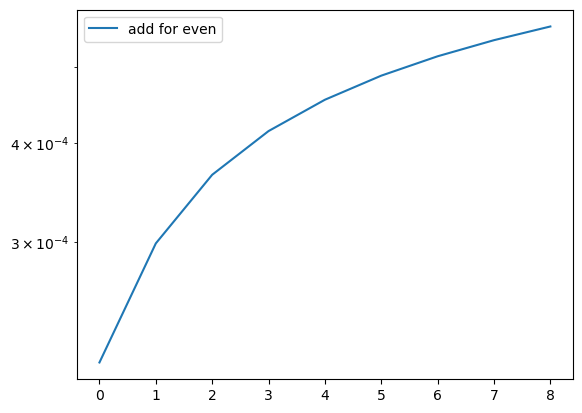

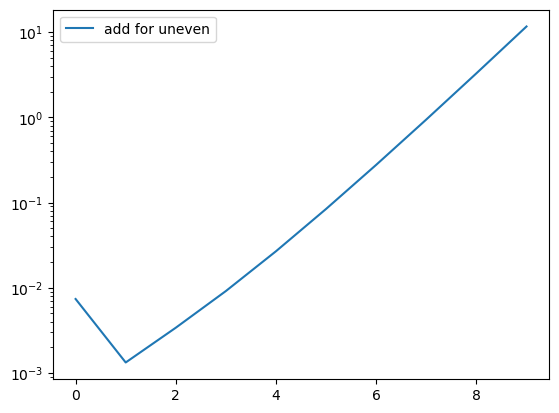

In [106]:
combined_list = [x + y for x, y in zip(meas_error_list_even, app_error_list_even)]
plt.plot(combined_list,label='add for even')
plt.legend()
plt.yscale('log')
plt.show()
combined_list = [x + y for x, y in zip(meas_error_list_uneven, app_error_list_uneven)]
plt.plot(combined_list,label='add for uneven')
plt.yscale('log')
plt.legend()

#### Analysis of Noise on derivative

In [107]:
target_noise=1e-9
var = target_noise * np.sqrt(np.mean(np.square(u)))
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
order=2
ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)

In [108]:
infinity_norm(ux-ux_noise)

2.3016738708303563e-05

In [109]:
eps=infinity_norm(u_noise-u)
M=infinity_norm(uxxx)
h=dx
print(f"eps: {eps}, M: {M}, h: {h}")

eps: 5.9943299213216505e-09, M: 2.718281828459045, h: 0.005025125628140704


##### With Boundary values
Error bound smaller than difference for oder =^1? -> wrong formula
three poiint midpoint ?/ numerical mistakes in error bound calcuation?<br>
What about the boundary values for central diff??? -> I think they are the reason the bound fails for some noise levels since we can not use central differnce at the boundary values!

Noise level 	  eps 	 	 $max|ux-ux_noise|$ 	 bound
0 	 	  0.0000 	 0.0000 	 	 0.0000
1e-10 	 	  0.0000 	 0.0000 	 	 0.0000
1e-09 	 	  0.0000 	 0.0000 	 	 0.0000
1e-08 	 	  0.0000 	 0.0000 	 	 0.0000
1e-07 	 	  0.0000 	 0.0002 	 	 0.0001
1e-06 	 	  0.0000 	 0.0020 	 	 0.0012
1e-05 	 	  0.0001 	 0.0260 	 	 0.0137
0.0001 	 	  0.0006 	 0.3155 	 	 0.1213
0.001 	 	  0.0067 	 1.8906 	 	 1.3418
0.01 	 	  0.0672 	 25.2810 	 	 13.3753
0.1 	 	  0.6066 	 230.6787 	 	 120.7117


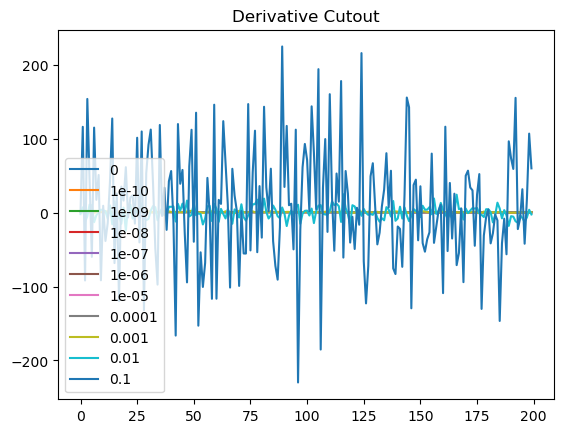

In [110]:
M=infinity_norm(uxxx)
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t  eps \t \t $max|ux-ux_noise|$ \t bound")
plt.title("Derivative Cutout")
order=2
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(u)))
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    plt.plot(ux_noise[0,:],label=str(target_noise))
    eps = infinity_norm(u_noise-u)
    bound = error_bound(eps,dx,M,order)
    diff = infinity_norm(ux-ux_noise)
    print(f"{target_noise} \t \t  {eps:.4f} \t {diff:.4f} \t \t {bound:.4f}")
plt.legend()
plt.show()

In [111]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        eps = infinity_norm(u_noise-u)
        bound = error_bound(eps,dx,M,order)
        diff = infinity_norm(ux-ux_noise)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
	 0	 	  0.000 	 0.0068 	 0.0068
	 1e-10	 	  0.000 	 0.0068 	 0.0068
	 1e-09	 	  0.000 	 0.0068 	 0.0068
	 1e-08	 	  0.000 	 0.0068 	 0.0069
	 1e-07	 	  0.000 	 0.0068 	 0.0071
	 1e-06	 	  0.000 	 0.0080 	 0.0097
	 1e-05	 	  0.000 	 0.0229 	 0.0320
	 0.0001	 	  0.001 	 0.1769 	 0.2915
	 0.001	 	  0.007 	 1.8852 	 2.6283
	 0.01	 	  0.062 	 17.6697 	 24.6576
2
	 0	 	  0.000 	 0.0000 	 0.0000
	 1e-10	 	  0.000 	 0.0000 	 0.0000
	 1e-09	 	  0.000 	 0.0000 	 0.0000
	 1e-08	 	  0.000 	 0.0000 	 0.0000
	 1e-07	 	  0.000 	 0.0003 	 0.0001
	 1e-06	 	  0.000 	 0.0020 	 0.0012
	 1e-05	 	  0.000 	 0.0212 	 0.0130
	 0.0001	 	  0.001 	 0.2339 	 0.1190
	 0.001	 	  0.007 	 2.1351 	 1.3678
	 0.01	 	  0.066 	 22.8514 	 13.1453
3
	 0	 	  0.000 	 0.0000 	 0.0000
	 1e-10	 	  0.000 	 0.0000 	 0.0000
	 1e-09	 	  0.000 	 0.0000 	 0.0000
	 1e-08	 	  0.000 	 0.0000 	 0.0001
	 1e-07	 	  0.000 	 0.0004 	 0.0009
	 1e-06	 	  0.000 	 0.0036 	 0.0083
	 1e-05	 	  0.

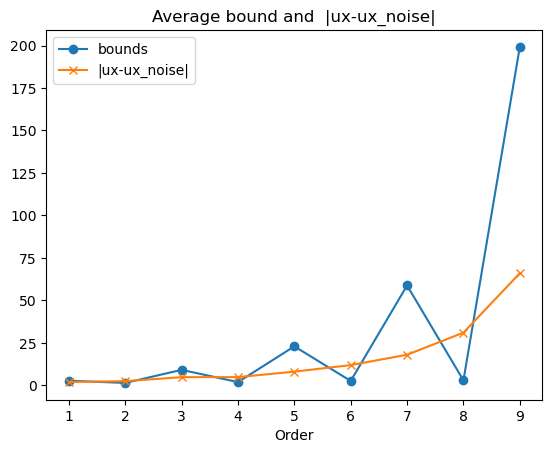

In [112]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()

##### Without boundary values

In [97]:
M=infinity_norm(uxxx)
number_noise=8 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(ux_noise).all(axis=1)
        col_mask = ~np.isnan(ux_noise).all(axis=0)
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound(eps,dx,M,order)
        diff = infinity_norm(ux[row_mask][:, col_mask]-ux_noise[row_mask][:, col_mask])
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*2.220e-16/5.025e-03 + 5.025e-03*1.616e+01*5.000e-01
	 0	 	  0.000 	 0.0405 	 0.0406
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*2.225e-09/5.025e-03 + 5.025e-03*1.616e+01*5.000e-01
	 1e-10	 	  0.000 	 0.0405 	 0.0406
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*2.541e-08/5.025e-03 + 5.025e-03*1.616e+01*5.000e-01
	 1e-09	 	  0.000 	 0.0405 	 0.0406
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*2.393e-07/5.025e-03 + 5.025e-03*1.616e+01*5.000e-01
	 1e-08	 	  0.000 	 0.0405 	 0.0407
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*2.277e-06/5.025e-03 + 5.025e-03*1.616e+01*5.000e-01
	 1e-07	 	  0.000 	 0.0404 	 0.0415
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*2.505e-05/5.025e-03 + 5.025e-03*1.616e+01*5.000e-01
	 1e-06	 	  0.000 	 0.0422 	 0.0506
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*2.477e-04/5.025e-03 + 5.025e-03*1.616e+01*5.000e-01
	 1e-05	 	  0.000 	 0.0899 	 0.1392
 C_me

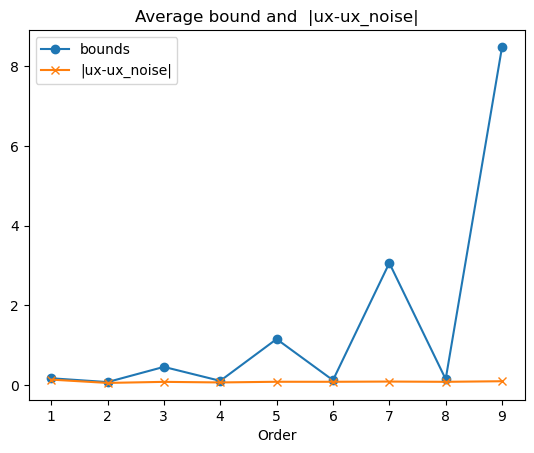

In [98]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()

Plot accuracy and bound depending on error

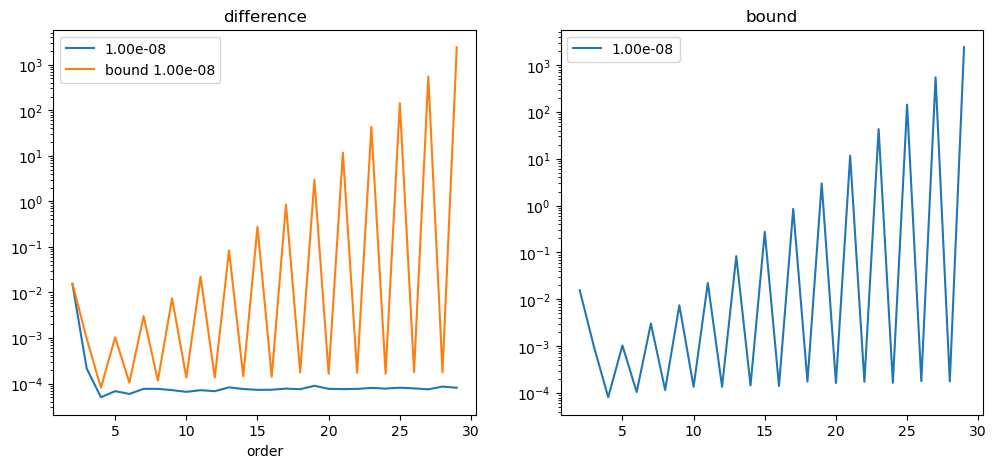

In [35]:
M=infinity_norm(uxxx)
number_noise=8 #<=10
noise_levels = [1e-8]#+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,30,1)
#print("Noise level \t Order \t  eps \t \t|ux-ux_noise| \t bound")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xlabel('order')
for target_noise in noise_levels:
    #print(f"{target_noise}")
    diff_list = []
    bound_list = []
    avg_diff=0
    avg_bound=0
    for order in orders:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(ux_noise).all(axis=1)
        col_mask = ~np.isnan(ux_noise).all(axis=0)
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound(eps,dx,M,order)
        diff = infinity_norm(ux[row_mask][:, col_mask]-ux_noise[row_mask][:, col_mask])
        avg_bound+=bound
        avg_diff+=diff
        diff_list.append(diff)
        bound_list.append(bound)
        #print(f"\t \t {order}\t \t  {eps:.5f} \t {diff:.5f} \t {bound:.5f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    plt.subplot(1,2,1)
    plt.title("difference")
    plt.plot(orders,diff_list,label = f"{target_noise:2.2e}")
    plt.plot(orders,bound_list,label = f"bound {target_noise:2.2e}")
    plt.legend()
    plt.yscale('log')
    plt.subplot(1,2,2)
    plt.yscale('log')
    plt.title("bound")
    plt.plot(orders,bound_list,label = f"{target_noise:2.2e}")
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)
plt.legend()    

## Put everything together: Finite Differences and SVD

Let $\|g-\tilde{g}\|_F^2 = \sum_{i=1}^{n}\|u_{\alpha_i}-\tilde{u}_{\alpha_i}\|^2 < \|u-\tilde{u}\|^2+ \sum_{i=2}^n m\text{ errorbound}({\alpha_i},\epsilon)^2 =E $
$$| \frac{\tilde{\sigma}_1}{\tilde{\sigma}_n} - \frac{\sigma_1}{\sigma_n} | < \sqrt{(\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2) E}$$

In [36]:
#Calculates E
#right now only for u and ux
"""
eps_two: ||u-u_noise||_2 two norm
eps_infty: ||u-u_noise||_infty infinity norm
h: dx for equispaced data
number_datapoints: number of total datapoints where u is evaluated
M: bound on nth derivative depending on the order
"""
def error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order):
    E = eps_two**2 + number_datapoints*error_bound(eps_infty,h,M,order)**2
    return E

"""
E: error bound on ||g-g_noise||_F^2 calculated in above function
sv_max: highest singular value on matrix without noise
sv_min: lowest singular value on matrix without noise
"""
def total_error_conditon(E,sv_max,sv_min):
    bound = np.sqrt(1/sv_min+(sv_max/sv_min**2)**2*E)
    return bound

In [74]:
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()#*1e-6
"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [75]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 5.633551097529296
Singular values of g: (761.0458664877826, 6.95525815715248e-14)
sv_max/sv_min: 1.094e+16


##### Check $\sum_{i=1}^{n}\|u_{\alpha_i}-\tilde{u}_{\alpha_i}\|^2 < \sum_{i=1}^n m \text{ errorbound}({\alpha_i},\epsilon)^2  $

In [76]:
order=1
target_noise=1e-10
var = target_noise * np.sqrt(np.mean(np.square(u)))
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
eps_two = np.linalg.norm(u-u_noise)
eps_infty = infinity_norm(u-u_noise)
M=infinity_norm(uxxx)

ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
print(f"|g-g_noise|: {np.linalg.norm(true_g-g_noise):3.2e}")
print(f"Bound: {np.sqrt(E):3.3e}")

 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.366e-09/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
|g-g_noise|: 1.35e+00
Bound: 2.831e+00


Check $| \frac{\tilde{\sigma}_1}{\tilde{\sigma}_n} - \frac{\sigma_1}{\sigma_n} | < (\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2) \sqrt{E}$

In [77]:
sv = svd(g_noise, compute_uv=False)
ratio = sv[0]/sv[-1]
print(f"|cond-cond_noise|: {np.abs(ratio-sv_max/sv_min):3.3e}")
print(f"Bound: {total_error_conditon(E,sv_max,sv_min):3.3e}")

|cond-cond_noise|: 1.094e+16
Bound: 4.454e+29


##### Do it for different orders and noise levels

In [78]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t |g-g_noise| \t sqrt(E) \t|c-c_noise| \t Bound")
unorm2=np.sqrt(np.mean(np.square(u)))
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * unorm2
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        eps_two = np.linalg.norm(u-u_noise)
        eps_infty = infinity_norm(u-u_noise)
        
        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        bound = total_error_conditon(E,sv_max,sv_min)
        diff = np.abs(ratio-sv_max/sv_min)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t  \t {np.linalg.norm(true_g-g_noise):3.2e} \t {np.sqrt(E):3.2e} \t{diff:3.8e} \t{bound:3.2e}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound
1
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*2.220e-16/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 0	  	 1.35e+00 	 2.83e+00 	1.09420218e+16 	4.45e+29
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.131e-09/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 1e-10	  	 1.35e+00 	 2.83e+00 	1.09420218e+16 	4.45e+29
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.098e-08/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 1e-09	  	 1.35e+00 	 2.83e+00 	1.09420218e+16 	4.45e+29
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.246e-07/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 1e-08	  	 1.35e+00 	 2.84e+00 	1.09420218e+16 	4.47e+29
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.216e-06/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 1e-07	  	 1.35e+00 	 2.93e+00 	1.09420218e+16 	4.61e+29
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.089e-05/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 1e-06	  	 1.36e+00 	 3.70e+00 	1.09420218e+16 	5.82

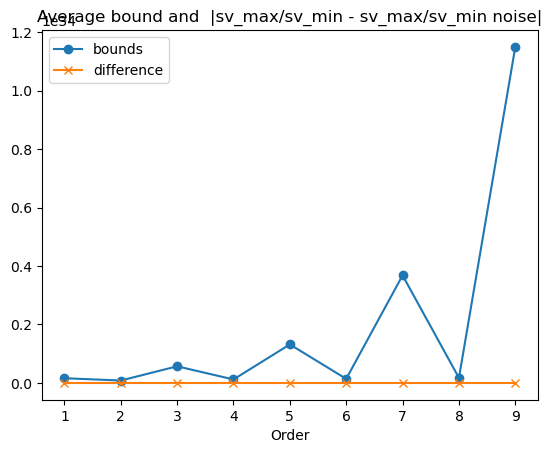

In [79]:
plt.title("Average bound and  |sv_max/sv_min - sv_max/sv_min noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='difference')
plt.legend()

##### Plot for each noise level the different orders:

For higher orders the error (at least for small enough noise i.e. noise <=1e-8) gets smaller.
It always gets better from order 1 to wo for noise <= 1e-5
If E is very small the approximaitn is not that bad.
Maybe a good lower bound would be 1e-8/1e-9/1e-10???

Note that the difference here revolves around 1e15(even for low noise levels) which is already pretty high
The difference never gets better after order=6 -> we do not need to consider this. What might be an explination for this behavior?

True ratio: 1.094e+16
Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0
0.0
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*2.220e-16/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 1.35e+00 	 2.83e+00 	1.09e+16 	4.45362e+29 	 3.735e+03
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*2.220e-16/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 5.99e-06 	 3.57e-05 	1.09e+16 	5.62313e+24 	 5.548e+08
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*2.220e-16/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 4.66e-11 	 7.53e-10 	1.09e+16 	1.18391e+20 	 3.012e+13
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*2.220e-16/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.69e-11 	 4.07e-10 	1.09e+16 	6.39819e+19 	 4.143e+13
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*2.220e-16/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 6.25e-11 	 1.19e-09 	1.09e+16 	1.87562e+20 	 1.723e+13


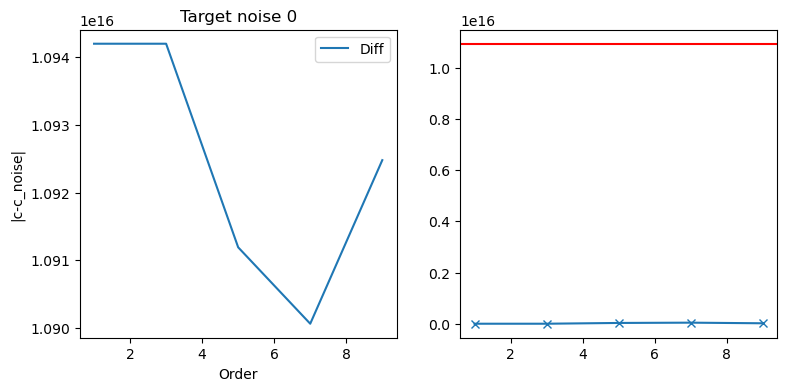

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-10
5.394280885570913e-08
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.189e-09/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 1.35e+00 	 2.83e+00 	1.09e+16 	4.45377e+29 	 3.735e+03
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*1.189e-09/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 1.45e-05 	 3.51e-04 	1.09e+16 	5.52610e+25 	 8.059e+07
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*1.189e-09/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 1.56e-05 	 8.08e-04 	1.09e+16 	1.27073e+26 	 6.883e+07
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*1.189e-09/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.59e-05 	 2.18e-03 	1.09e+16 	3.42643e+26 	 4.159e+07
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*1.189e-09/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 6.19e-05 	 6.38e-03 	1.09e+16 	1.00448e+27 	 1.737e+07


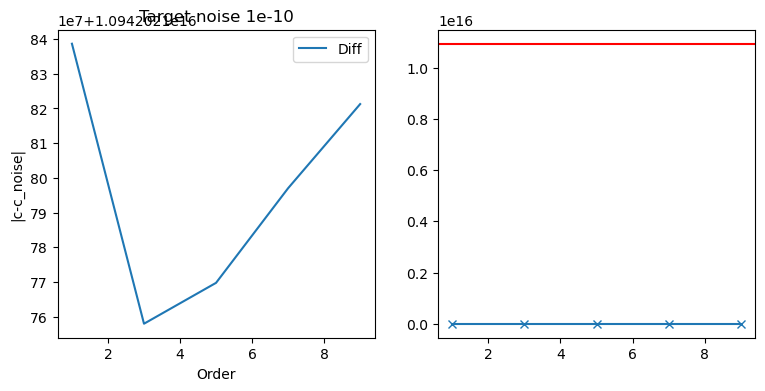

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-09
5.41003036080644e-07
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.136e-08/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 1.35e+00 	 2.83e+00 	1.09e+16 	4.45505e+29 	 3.735e+03
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*1.136e-08/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 1.33e-04 	 3.05e-03 	1.09e+16 	4.79845e+26 	 8.081e+06
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*1.136e-08/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 1.57e-04 	 7.72e-03 	1.09e+16 	1.21401e+27 	 6.828e+06
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*1.136e-08/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.56e-04 	 2.08e-02 	1.09e+16 	3.27349e+27 	 4.207e+06
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*1.136e-08/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 6.08e-04 	 6.10e-02 	1.09e+16 	9.59644e+27 	 1.770e+06


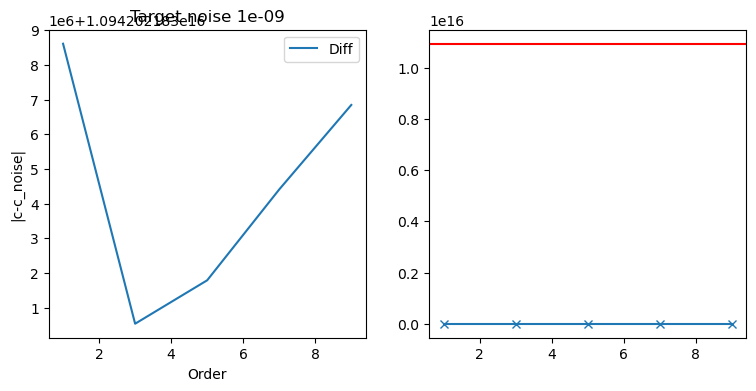

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-08
5.377695540241855e-06
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.274e-07/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 1.35e+00 	 2.84e+00 	1.09e+16 	4.46958e+29 	 3.734e+03
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*1.274e-07/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 1.33e-03 	 3.38e-02 	1.09e+16 	5.32303e+27 	 8.094e+05
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*1.274e-07/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 1.57e-03 	 8.65e-02 	1.09e+16 	1.36126e+28 	 6.849e+05
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*1.274e-07/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.51e-03 	 2.33e-01 	1.09e+16 	3.67053e+28 	 4.295e+05
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*1.274e-07/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 6.06e-03 	 6.84e-01 	1.09e+16 	1.07604e+29 	 1.776e+05


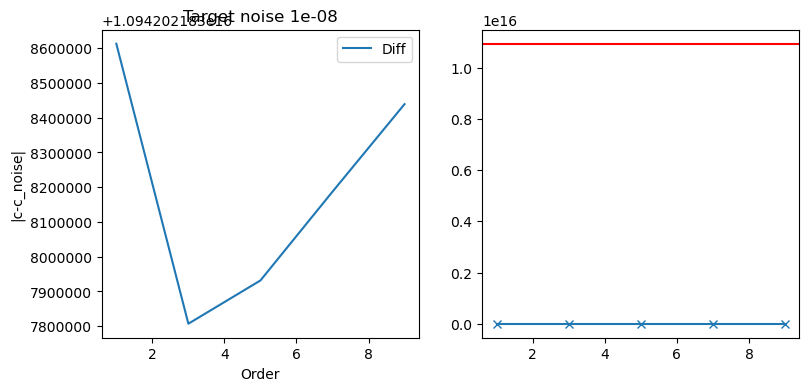

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-07
5.384400391336758e-05
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.028e-06/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 1.35e+00 	 2.91e+00 	1.09e+16 	4.58236e+29 	 3.730e+03
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*1.028e-06/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 1.31e-02 	 2.73e-01 	1.09e+16 	4.29174e+28 	 8.174e+04
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*1.028e-06/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 1.52e-02 	 6.98e-01 	1.09e+16 	1.09854e+29 	 7.061e+04
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*1.028e-06/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.40e-02 	 1.88e+00 	1.09e+16 	2.96214e+29 	 4.491e+04
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*1.028e-06/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 5.83e-02 	 5.52e+00 	1.09e+16 	8.68371e+29 	 1.846e+04


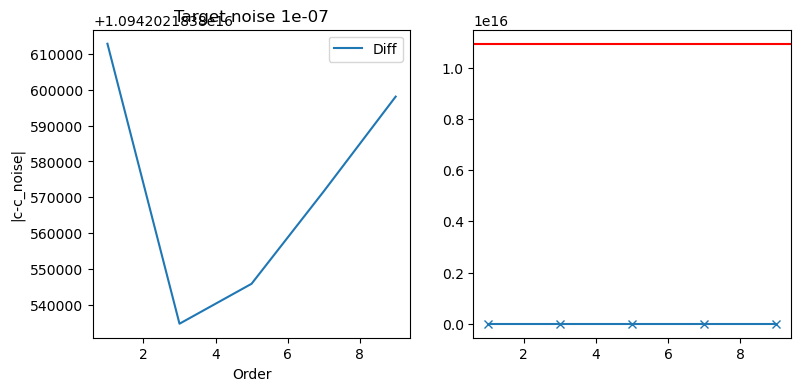

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-06
0.0005384420935415079
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.151e-05/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 1.36e+00 	 3.75e+00 	1.09e+16 	5.89525e+29 	 3.299e+03
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*1.151e-05/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 1.32e-01 	 3.05e+00 	1.09e+16 	4.80548e+29 	 8.142e+03
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*1.151e-05/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 1.55e-01 	 7.82e+00 	1.09e+16 	1.23019e+30 	 6.936e+03
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*1.151e-05/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.56e-01 	 2.11e+01 	1.09e+16 	3.31711e+30 	 4.200e+03
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*1.151e-05/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 6.23e-01 	 6.18e+01 	1.09e+16 	9.72434e+30 	 1.728e+03


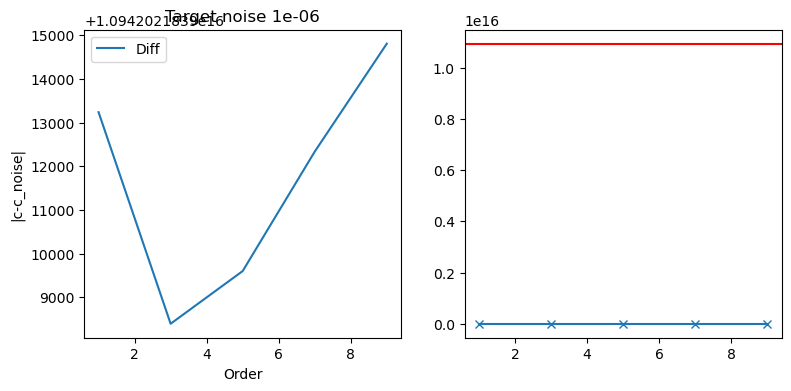

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-05
0.005363020318021575
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.135e-04/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 2.03e+00 	 1.19e+01 	1.09e+16 	1.86675e+30 	 6.986e+02
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*1.135e-04/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 1.32e+00 	 3.01e+01 	1.09e+16 	4.73796e+30 	 8.124e+02
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*1.135e-04/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 1.57e+00 	 7.71e+01 	1.09e+16 	1.21292e+31 	 6.861e+02
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*1.135e-04/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.53e+00 	 2.08e+02 	1.09e+16 	3.27054e+31 	 4.253e+02
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*1.135e-04/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 6.05e+00 	 6.09e+02 	1.09e+16 	9.58781e+31 	 1.778e+02


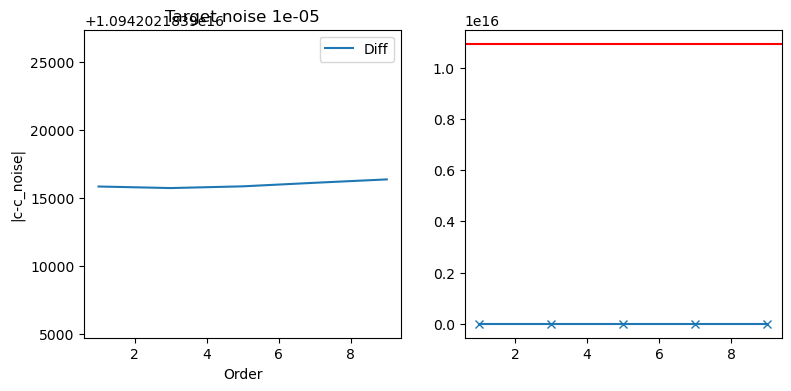

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0.0001
0.05387457728288315
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.223e-03/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 1.52e+01 	 1.00e+02 	1.09e+16 	1.57579e+31 	 7.107e+01
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*1.223e-03/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 1.32e+01 	 3.24e+02 	1.09e+16 	5.10418e+31 	 8.116e+01
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*1.223e-03/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 1.57e+01 	 8.31e+02 	1.09e+16 	1.30667e+32 	 6.832e+01
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*1.223e-03/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.63e+01 	 2.24e+03 	1.09e+16 	3.52334e+32 	 4.092e+01
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*1.223e-03/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 6.56e+01 	 6.57e+03 	1.09e+16 	1.03289e+33 	 1.646e+01


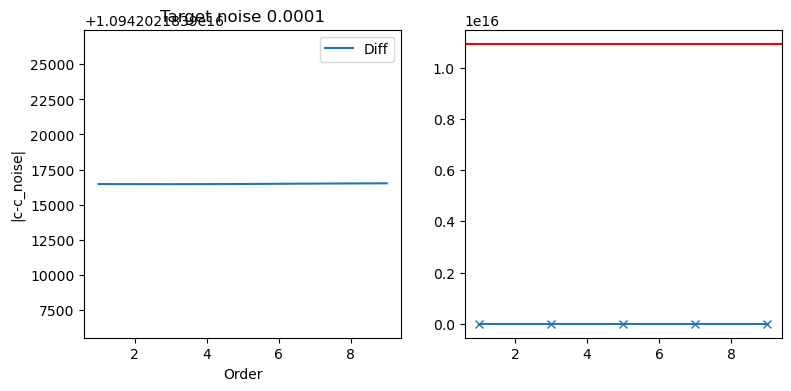

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0.001
0.5379888237428697
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.095e-02/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 1.52e+02 	 8.74e+02 	1.09e+16 	1.37562e+32 	 7.243e+00
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*1.095e-02/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 1.32e+02 	 2.91e+03 	1.09e+16 	4.57056e+32 	 8.266e+00
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*1.095e-02/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 1.58e+02 	 7.44e+03 	1.09e+16 	1.17006e+33 	 6.956e+00
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*1.095e-02/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.60e+02 	 2.01e+04 	1.09e+16 	3.15499e+33 	 4.397e+00
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*1.095e-02/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 6.06e+02 	 5.88e+04 	1.09e+16 	9.24907e+33 	 2.516e+00


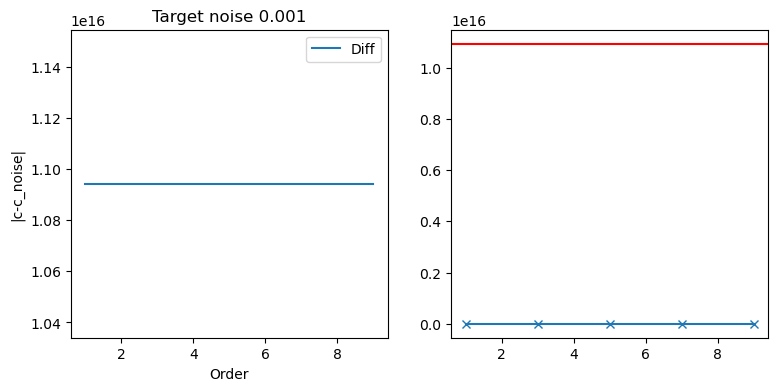

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0.01
5.372594014044896
 C_meas*eps/h + (h**order)*M*C_app = 2.000e+00*1.374e-01/5.025e-03 + 5.025e-03*5.634e+00*5.000e-01
	 	 1	  	 1.52e+03 	 1.09e+04 	1.09e+16 	1.72054e+33 	 3.208e+00
 C_meas*eps/h + (h**order)*M*C_app = 6.667e+00*1.374e-01/5.025e-03 + 1.269e-07*5.634e+00*2.500e-01
	 	 3	  	 1.32e+03 	 3.64e+04 	1.09e+16 	5.73366e+33 	 2.917e+00
 C_meas*eps/h + (h**order)*M*C_app = 1.707e+01*1.374e-01/5.025e-03 + 3.204e-12*5.634e+00*1.667e-01
	 	 5	  	 1.54e+03 	 9.33e+04 	1.09e+16 	1.46782e+34 	 3.250e+00
 C_meas*eps/h + (h**order)*M*C_app = 4.602e+01*1.374e-01/5.025e-03 + 8.091e-17*5.634e+00*1.250e-01
	 	 7	  	 2.52e+03 	 2.52e+05 	1.09e+16 	3.95786e+34 	 4.888e+00
 C_meas*eps/h + (h**order)*M*C_app = 1.349e+02*1.374e-01/5.025e-03 + 2.043e-21*5.634e+00*1.000e-01
	 	 9	  	 6.05e+03 	 7.38e+05 	1.09e+16 	1.16027e+35 	 1.131e+01


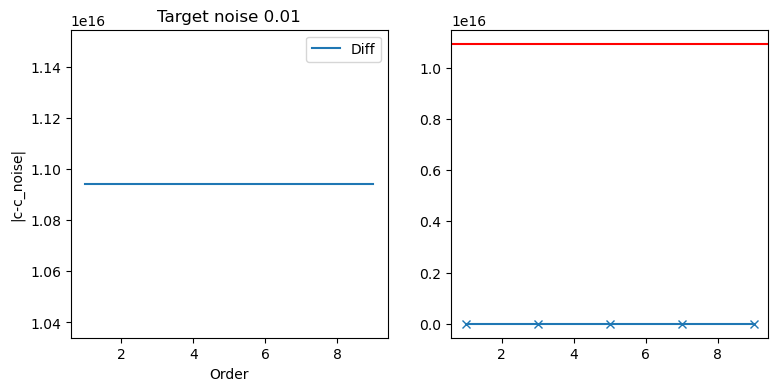

In [80]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,2)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t |g-g_noise| \t sqrt(E) \t|c-c_noise| \t Bound \t \t ratio")
    print(f"{target_noise}")
    diff_list = []
    bound_list = []
    ratio_list=[]
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)
    
    for order in orders:        
        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        bound = total_error_conditon(E,sv_max,sv_min)
        diff = np.abs(ratio-sv_max/sv_min)
        bound_list.append(bound)
        diff_list.append(diff)
        ratio_list.append(ratio)
        
        print(f"\t \t {order}\t  \t {np.linalg.norm(true_g-g_noise):3.2e} \t {np.sqrt(E):3.2e} \t{diff:3.2e} \t{bound:3.5e} \t {ratio:3.3e}")

    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.title(f"Target noise {target_noise}")
    plt.plot(orders,diff_list,label="Diff")
    #plt.plot(orders,bound_list,label="bound")
    #plt.plot(orders,ratio_list,label="ratio")
    plt.legend()
    #plt.yscale('log')
    plt.xlabel('Order')
    plt.ylabel('|c-c_noise|')
    plt.subplot(1,2,2)
    plt.plot(orders,ratio_list, marker='x',label="ratio")
    plt.axhline(y=sv_max/sv_min, color='r', label='true ratio')
    plt.show()

##### lets look at one specific example to find the reason for the "knick"

In [81]:
import pandas as pd

No handles with labels found to put in legend.


SV_min: 6.95525815715248e-14, SV_max: 761.0458664877826, Ratio 1.0942021838616538e+16
1e-10
5.365742102918273e-08
order 1
order 2
order 3
order 4
order 5
order 6
order 7
order 8
order 9
   order   |g-g_noise|              E   |c-c_noise|         bound  \
0      1  3.390030e+06  341250.942025  1.094202e+16  5.368565e+34   
1      2  3.370824e+06    2858.048100  1.094202e+16  4.496285e+32   
2      3  3.370671e+06     107.715441  1.094202e+16  1.694581e+31   
3      4  3.370673e+06       0.360869  1.094202e+16  5.677200e+28   
4      5  3.370673e+06       0.045490  1.094202e+16  7.156459e+27   
5      6  3.370673e+06       0.000066  1.094177e+16  1.031900e+25   
6      7  3.370673e+06       0.000443  1.094109e+16  6.962622e+25   
7      8  3.370673e+06       0.000019  1.094138e+16  3.000276e+24   
8      9  3.370673e+06       0.001235  1.094162e+16  1.942165e+26   

          ratio       sv_max       sv_min   ux-ux_noise        boundux  
0  3.729264e+02  9091.412214  9091.412214  30174.1

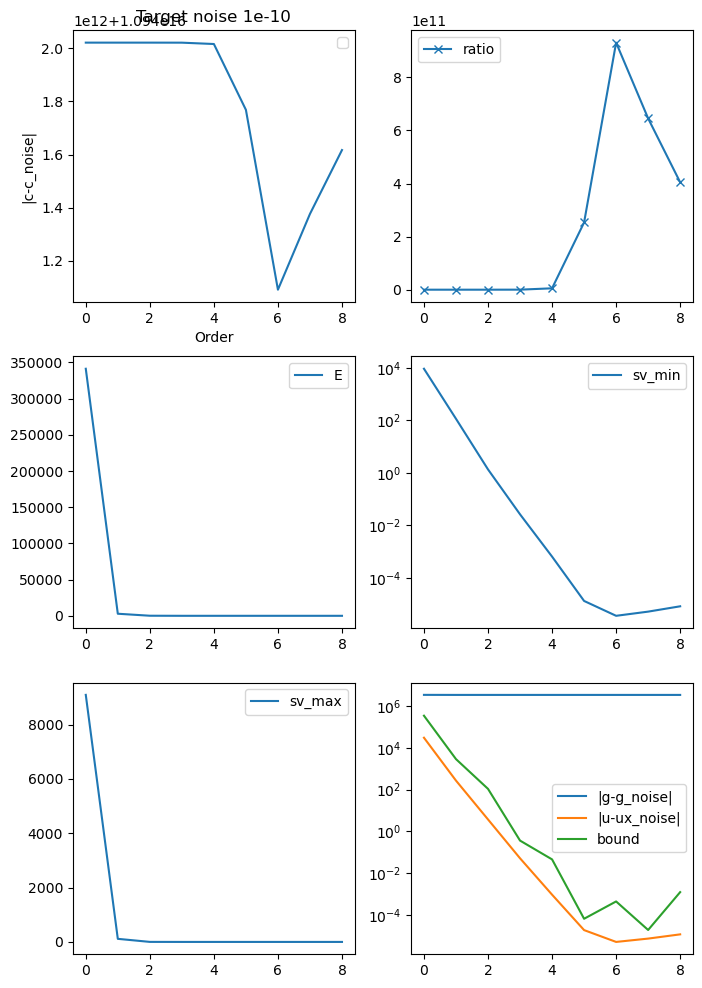

In [119]:
target_noise=1e-10
orders=range(1,10,1)
print(f"SV_min: {sv_min}, SV_max: {sv_max}, Ratio {sv_max/sv_min}")
df = pd.DataFrame(columns = ['order','|g-g_noise|', 'E', '|c-c_noise|','bound','ratio','sv_max','sv_min','ux-ux_noise','boundux'])
print(f"{target_noise}")
var = target_noise * unorm2
noise = np.random.normal(0, var, size=u.shape)
print(np.linalg.norm(noise))
u_noise = u + noise
eps_two = np.linalg.norm(u-u_noise)
eps_infty = infinity_norm(u_noise-u)
M=infinity_norm(uxxx)

for order in orders:  
    print(f"order {order}")
    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
    sv = svd(g_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = total_error_conditon(E,sv_max,sv_min)
    diff = np.abs(ratio-sv_max/sv_min)
    boundux = np.sqrt(true_g.shape[0])*error_bound(eps_infty,dx,M,order)
    new_row = {'order': order, '|g-g_noise|': np.linalg.norm(true_g-g_noise), 'E': np.sqrt(E), '|c-c_noise|': diff,'bound':bound,'ratio':ratio,'sv_max':sv[1],
               'sv_min':sv[-1],'ux-ux_noise':np.linalg.norm(ux-ux_noise),'boundux':boundux}
    df.loc[len(df)] = new_row
    
print(df)
plt.figure(figsize=(8,12))
plt.subplot(3,2,1)
plt.title(f"Target noise {target_noise}")
plt.plot(df["|c-c_noise|"])
plt.legend()
plt.xlabel('Order')
plt.ylabel('|c-c_noise|')
plt.subplot(3,2,2)
plt.plot(df["ratio"], marker='x',label='ratio')
#plt.axhline(y=sv_max/sv_min, color='r', label='true ratio')
plt.legend()
plt.subplot(3,2,3)
plt.plot(df["E"],label='E')
plt.legend()
plt.subplot(3,2,4)
plt.plot(df["sv_min"],label='sv_min')
plt.yscale('log')
plt.legend()
plt.subplot(3,2,5)
plt.plot(df["sv_max"],label='sv_max')
plt.legend()
plt.subplot(3,2,6)
plt.plot(df["|g-g_noise|"],label='|g-g_noise|')
plt.plot(df["ux-ux_noise"],label='|ux-ux_noise|')
plt.plot(df['boundux'],label='bound')# currently bound is wrong why???
plt.yscale('log')
plt.legend()
plt.show()